In [1]:
from datetime import datetime
import itertools
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from database import data_utils, data_loader
from models import basic_nn

import importlib
importlib.reload(basic_nn)
importlib.reload(data_loader)

<module 'database.data_loader' from '/Users/zack/Desktop/valle/src/database/data_loader.py'>

In [2]:
# Read in config
with open("../results/kcm2weeks/data/config.json", "r") as f:
    kcm_config = json.load(f)
# Read in train data
kcm_data_train = []
for i in range(0,5):
    kcm_contents = open("../results/kcm2weeks/data/train_0"+str(i), "r").read()
    kcm_data_train.append([json.loads(str(item)) for item in kcm_contents.strip().split('\n')])
kcm_data_train = list(itertools.chain.from_iterable(kcm_data_train))
# Read in test data
kcm_contents = open("../results/kcm2weeks/data/test", "r").read()
kcm_data_valid = [json.loads(str(item)) for item in kcm_contents.strip().split('\n')]

In [3]:
# Set hyperparameters
EPOCHS = 30
BATCH_SIZE = 512
LEARN_RATE = 1e-3
HIDDEN_SIZE = 512

# Use acceleration if available
device = torch.device("cpu")

# Make data loaders
dataloader_train = data_loader.make_dataloader(kcm_data_train, kcm_config, BATCH_SIZE, device)
dataloader_valid = data_loader.make_dataloader(kcm_data_valid, kcm_config, BATCH_SIZE, device)

# Initialize model
# KCM: 1147
# NWY: 646
embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 16,
        'col': 4
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 16,
        'col': 5
    }
}
model = basic_nn.BasicNeuralNet(dataloader_train.dataset[0][0].shape[0], embed_dict, HIDDEN_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
loss_fn = torch.nn.MSELoss()

print(f"Using device: {device}")
print(f"Model: {model}")

Using device: cpu
Model: BasicNeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (embeddingTimeID): Embedding(1440, 16)
  (embeddingWeekID): Embedding(7, 16)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=36, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [4]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
best_vloss = 100000000.

training_loss = []
validation_loss = []
training_steps = len(dataloader_train)
validation_steps = len(dataloader_valid)

for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch_number}')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    running_tloss = 0.0
    last_loss = 0.0

    # Iterate over all batches per-epoch
    for i, data in enumerate(dataloader_train):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Run forward/backward
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()

        # Adjust weights
        optimizer.step()

        # Gather data and report
        running_tloss += loss.item()

    # We don't need gradients on to do reporting
    model.train(False)

    avg_batch_loss = running_tloss / training_steps
    training_loss.append(avg_batch_loss)

    running_vloss = 0.0
    for i, vdata in enumerate(dataloader_valid):
        vinputs, vlabels = vdata
        vpreds = model(vinputs)
        vloss = loss_fn(vpreds, vlabels)
        running_vloss += vloss
    avg_valid_loss = running_vloss / validation_steps
    validation_loss.append(avg_valid_loss.item())

    print(f'LOSS: train {avg_batch_loss} valid {avg_valid_loss}')

    # Track best performance, and save the model's state
    if avg_valid_loss < best_vloss:
        best_vloss = avg_valid_loss
        model_path = f'../results/basic_nn/model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH: 0
LOSS: train 323.06172858344183 valid 228.7010955810547
EPOCH: 1
LOSS: train 193.0539599524604 valid 184.70030212402344
EPOCH: 2
LOSS: train 155.0384554862976 valid 154.88723754882812
EPOCH: 3
LOSS: train 135.8040130403307 valid 146.41558837890625
EPOCH: 4
LOSS: train 129.05189275741577 valid 138.4940643310547
EPOCH: 5
LOSS: train 124.39680586920844 valid 133.96665954589844
EPOCH: 6
LOSS: train 119.70612112681071 valid 129.2615203857422
EPOCH: 7
LOSS: train 115.37286281585693 valid 124.00789642333984
EPOCH: 8
LOSS: train 110.79805755615234 valid 119.66091918945312
EPOCH: 9
LOSS: train 105.79482179217868 valid 114.3582763671875
EPOCH: 10
LOSS: train 101.56376515494452 valid 112.26038360595703
EPOCH: 11
LOSS: train 97.50748480690851 valid 107.17005920410156
EPOCH: 12
LOSS: train 94.33636299769084 valid 104.121826171875
EPOCH: 13
LOSS: train 91.37758329179552 valid 102.57996368408203
EPOCH: 14
LOSS: train 89.24475908279419 valid 100.44447326660156
EPOCH: 15
LOSS: train 87.18622530

<AxesSubplot: xlabel='Epoch', ylabel='value'>

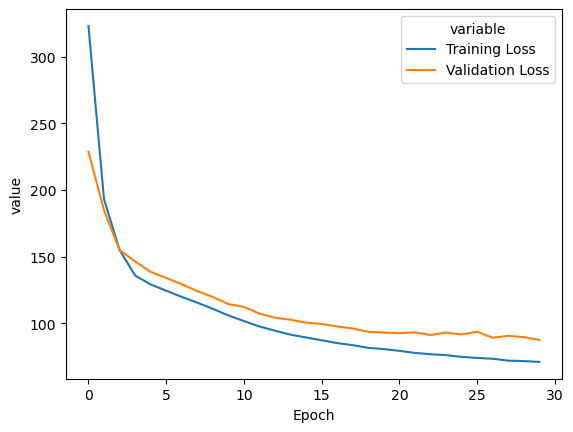

In [5]:
# Plot training curves
plot_data = pd.DataFrame(
    {
        "Epoch": [x for x in range(0,len(training_loss))],
        "Training Loss": training_loss,
        "Validation Loss": validation_loss
    }
)

sns.lineplot(x='Epoch', y='value', hue='variable', data=pd.melt(plot_data, ['Epoch']))